In [47]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [48]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [49]:
#nltk.download()

# Loading Data and Pre-processing

In [50]:
my_columns = [
    'user_id', #1 user identifier
    'status_id', #1 status identifier
    #'created_at', #1 before or after debate
    #'screen_name', #1 profile screen name 
    'text', #1 tweet text
    'Y/N', #1 LABEL
    'display_text_width', #1 length
    'is_quote', #1 Whether the tweet is an original one or quoted one
    'favorite_count', #1
    'retweet_count',  #1
    #'quote_count', #1 All blank
    #'reply_count', #1 All blank
    'hashtags', #1
    'media_type', #1 contains just text or media (media = photo / video) contents: ‘photo’ / BLANK -> 'text'
    'mentions_screen_name', #1 Name
    #'quoted_source', #? TO BE DECIDED
    'followers_count', #1 info related to profile
    'friends_count', #1 info related to profile
    'listed_count', #1 info related to profile TO BE DECIDED
    'statuses_count', #1 info related to profile
    'favourites_count', #1 info related to profile
    'verified', #1 whether the profile is verified
]

In [64]:
file_name = 'proudboys-labelled.csv'
data = pd.read_csv(file_name, encoding='ISO-8859-1')
data = data[my_columns]
print(data.shape)

(2014, 17)


**Processing the Labels**

- Remove unlabled data
- Replace the original labels

In [52]:
# Remove the unlabeled data
data = data.dropna(subset=['Y/N'])
print(data.shape)

(2014, 17)


In [53]:
data['Supportive'] = data['Y/N'].str.contains('Y')
data['Offensive'] = data['Y/N'].str.contains('O')

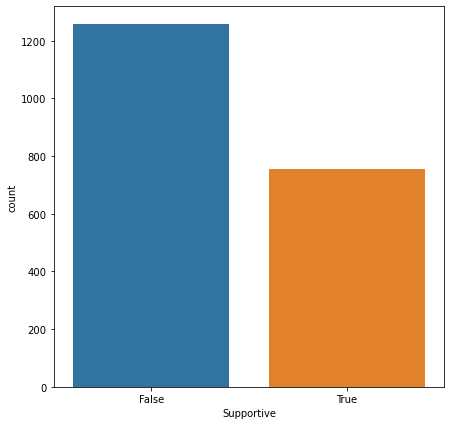

False    1257
True      757
Name: Supportive, dtype: int64
False    1712
True      302
Name: Offensive, dtype: int64


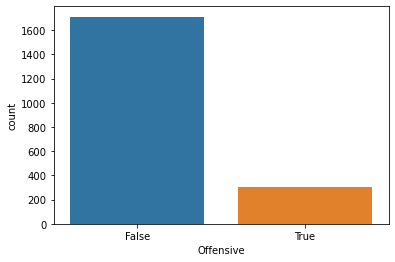

In [62]:
plt.figure(figsize=(7,7))
sns.countplot(data=data, x='Supportive')
plt.show()
print(data['Supportive'].value_counts())
sns.countplot(data=data, x='Offensive')
print(data['Offensive'].value_counts())
plt.show()

In [11]:
data['media_type'] = data['media_type'].fillna('plain_text')

**Processing the Hashtags**

Replace:
    
- 'alllivesmatters' -> 'alllivesmatter'
- 'antifacist', 'antifascists' -> 'antifa'
- 'blacklivesmatter', 'blacklivesstillmatter', 'blacklivesmatter' -> 'blm'
- 'kag2020' -> 'kag'
- 'maga2020' -> 'maga'
- 'oregoncity' -> 'oregon'
- 'portlandprotestors' -> 'portlandprotesters'
- 'protests', 'protest2020', 'protests2020' -> 'protest'
- 'trump2020' -> 'trump'

In [12]:
data['hashtags_proc'] = data['hashtags'].str.lower()
data['hashtags_proc'] = data['hashtags_proc'].fillna('blank')

ht_replacements = {
    'alllivesmatters': 'alllivesmatter',
    'antifacist': 'antifa',
    'antifascists':'antifa',
    'blacklivesmatter': 'blm',
    'blacklivesstillmatter': 'blm',
    'blacklivematter': 'blm',
    'kag2020': 'kag',
    'maga2020': 'maga',
    'oregoncity': 'oregon',
    'portlandprotestors': 'portlandprotesters',
    'protests': 'protest',
    'protest2020': 'protest',
    'protests2020': 'protest',
    'trump2020': 'trump',
}

for k, v in ht_replacements.items():
    data['hashtags_proc'] = data['hashtags_proc'].str.replace(k, v, regex=True)

## Adding New Features

In [13]:
data['hashtags_count'] = data['hashtags'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
data['hashtags_count'] = data['hashtags_count'].apply(lambda n: 3 if n > 2 else n)

data['hashtags_count'].head()

0    0
1    0
2    0
3    1
4    0
Name: hashtags_count, dtype: int64

In [14]:
data['mention_count'] = data['mentions_screen_name'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
data['mention_count'] = data['mention_count'].apply(lambda n: 4 if n > 3 else n)

data['mention_count'].head()

0    0
1    2
2    0
3    0
4    2
Name: mention_count, dtype: int64

In [15]:
data['exclamation_count'] = data['text'].str.count('\!')
data['exclamation_count'] = data['exclamation_count'].apply(lambda n: 3 if n > 2 else n)

data['question_count'] = data['text'].str.count('\?')
data['question_count'] = data['question_count'].apply(lambda n: 3 if n > 2 else n)

In [99]:
#data.info()
#print(data['is_quote'].value_counts())
#print(data['media_type'].value_counts())
#print(data['verified'].value_counts())
#print(data['supportive'].value_counts())
#print(data['offensive'].value_counts())
#print(data['exclamation_count'].value_counts())
#print(data['question_count'].value_counts())
#print(data['hashtags_count'].value_counts())
#print(data['mention_count'].value_counts())
#print(data['followers_count'].value_counts().sort_index())

### Remove URLs, Hashtags, Mentions

In [16]:
data['text_proc'] = data['text'].str.lower()
data['text_proc'] = data['text_proc'].str.replace(r"http\S+", "", regex=True)
data['text_proc'] = data['text_proc'].str.replace(r"#\S+", "", regex=True)
data['text_proc'] = data['text_proc'].str.replace(r"@\S+", "", regex=True)

Pre-processing Steps:

    1. Lower case
    2. Word tokenize
    3. Removing numbers and punctuations
    4. Word stemming

In [17]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['text_proc'])
    words = [word for word in words if word.isalpha()]
    data.loc[idx, 'lem_text'] = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))])
    words = [stemmer.stem(word) for word in words if word not in set(stopwords.words('english'))]
    data.loc[idx, 'text_proc'] = ' '.join(words)
    

data.head()

,user_id,status_id,text,Y/N,display_text_width,is_quote,favorite_count,retweet_count,hashtags,media_type,...,verified,supportive,offensive,hashtags_proc,hashtags_count,mention_count,exclamation_count,question_count,text_proc,lem_text
0,x382691414,x1297365508300447744,Proud boys are attacking Peaceful protesters i...,N,115,False,0,0,NaN,photo,...,False,False,False,blank,0,0,0,0,proud boy attack peac protest portland portlan...,proud boy attacking peaceful protester portlan...
1,x743936431,x1297365466306904066,"@Medde13 @MrAndyNgo I live in Portland, proud ...",N,189,False,0,0,NaN,plain_text,...,False,False,False,blank,0,2,0,0,live portland proud boy white supremacist hate...,live portland proud boy white supremacist hate...
2,x743936431,x1294749099976036353,Anyone else wondering why tRump and his deplor...,"N, O",175,False,9,0,NaN,plain_text,...,False,False,True,blank,0,0,0,1,anyon els wonder trump deplor base speak conde...,anyone else wondering trump deplorable base sp...
3,x375304364,x1297365456190406662,Not Antifa but the Right Wing Proud Boys. If y...,Y,126,True,0,0,CriticalThinking,plain_text,...,False,True,False,criticalthinking,1,0,0,0,antifa right wing proud boy think far left cau...,antifa right wing proud boy think far left cau...
4,x176941218,x1297365411533643776,@MARCIAN2003 @JoshuaPotash The police and the ...,N,42,False,0,0,NaN,plain_text,...,False,False,False,blank,0,2,0,0,polic proud boy,police proud boy


# Word Cloud

In [25]:
from PIL import Image
from wordcloud import WordCloud

mask = np.array(Image.open('cloud.png'))
wc_o = WordCloud(background_color='white', max_words=150)#, mask=mask)
wc_offensive = wc_o.generate(' '.join(data[data['offensive'] == True]['lem_text']))

wc_no = WordCloud(background_color='white', max_words=200)#, mask=mask)
wc_nonoffensive = wc_no.generate(' '.join(data[data['offensive'] == False]['lem_text']))

wc_s = WordCloud(background_color='white', max_words=150)#, mask=mask)
wc_supportive = wc_s.generate(' '.join(data[data['supportive'] == True]['lem_text']))

wc_ns = WordCloud(background_color='white', max_words=150)#, mask=mask)
wc_nonsupportive = wc_ns.generate(' '.join(data[data['supportive'] == False]['lem_text']))

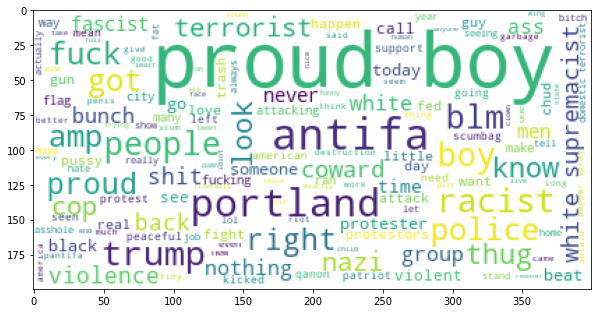

In [26]:
plt.figure(figsize=(10,7))
plt.imshow(wc_offensive)

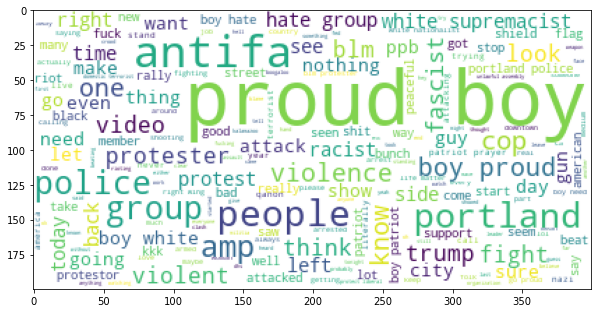

In [28]:
plt.figure(figsize=(10,7))
plt.imshow(wc_nonoffensive)

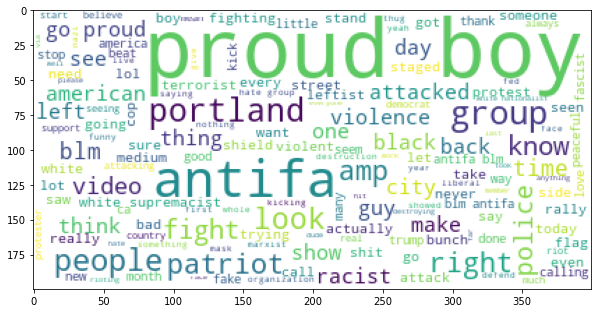

In [29]:
plt.figure(figsize=(10,7))
plt.imshow(wc_supportive)

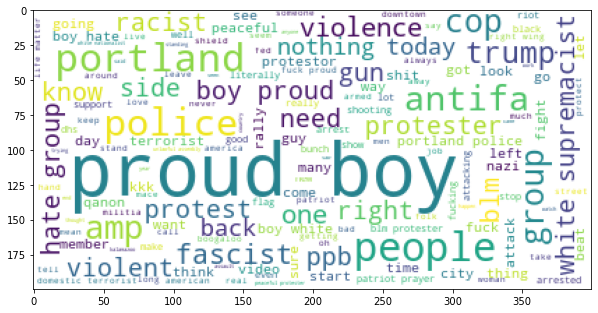

In [31]:
plt.figure(figsize=(10,7))
plt.imshow(wc_nonsupportive)

**Removing Common Words**

In [138]:
from collections import Counter
MOST_COMMON = 10
counter_supportive = Counter(" ".join(data["text_proc"][data['supportive'] == True]).split()).most_common(MOST_COMMON)
counter_nonsupportive = Counter(" ".join(data["text_proc"][data['supportive'] == False]).split()).most_common(MOST_COMMON)

In [139]:
df1 = pd.DataFrame(counter_supportive, columns =['word', 'freq_supportive'])
df1 = df1.set_index('word')
df2 = pd.DataFrame(counter_nonsupportive, columns=['word', 'freq_non_supportive'])
df2 = df2.set_index('word')

common_supportive = pd.concat([df1,df2],axis=1)
#print(common_supportive)

remove_supportive = []
for idx, row in common_supportive.iterrows():
    if row[0] > 0 and row[1] > 0:
        remove_supportive.append(idx)

In [140]:
print(len(remove_supportive), remove_supportive)
print(common_supportive)
remove_supportive = set(remove_supportive)

6 ['boy', 'proud', 'antifa', 'like', 'group', 'portland']
          freq_supportive  freq_non_supportive
boy                 795.0               1262.0
proud               790.0               1264.0
antifa              254.0                115.0
like                101.0                139.0
group                77.0                157.0
fight                69.0                  NaN
portland             62.0                207.0
look                 62.0                  NaN
blm                  58.0                  NaN
go                   58.0                  NaN
polic                 NaN                195.0
protest               NaN                168.0
peopl                 NaN                155.0
white                 NaN                104.0


In [141]:
for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['text_proc'])
    words = [word for word in words if word not in remove_supportive]
    data.loc[idx, 'lem_text'] = ' '.join([lemmatizer.lemmatize(word) for word in words])
    words = [stemmer.stem(word) for word in words]
    data.loc[idx, 'text_proc'] = ' '.join(words)

In [142]:
wc_s = WordCloud(background_color='white', max_words=200, mask=mask)
wc_supportive = wc_s.generate(' '.join(data[data['supportive'] == True]['lem_text']))

wc_ns = WordCloud(background_color='white', max_words=200, mask=mask)
wc_nonsupportive = wc_ns.generate(' '.join(data[data['supportive'] == False]['lem_text']))

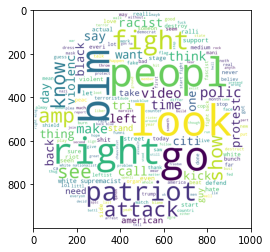

In [143]:
plt.imshow(wc_supportive)

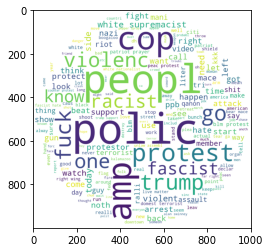

In [144]:
plt.imshow(wc_nonsupportive)

# Linguistic Features

Bag of Words (**X1**)

In [200]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2000) # CountVectorizer(ngram_range=(2,2))
X1 = cv.fit_transform(data['text_proc']).toarray()

In [223]:
X1.shape

(2014, 2000)

N-gram (**X3**)

In [32]:
# N-Gram
from sklearn.feature_extraction.text import CountVectorizer
cv1 = CountVectorizer(ngram_range=(1,3))
X3 = cv1.fit_transform(data['text_proc']).toarray()

In [46]:
vocab = cv1.vocabulary_

count_values = X3.sum(axis=0)

for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    if ng_text.count(' ') == 2:
        print(ng_count, ng_text)

46 proud boy white
45 like proud boy
34 proud boy hate
33 boy hate group
31 proud boy patriot
29 boy white supremacist
26 proud boy antifa
26 go proud boy
25 proud boy show
25 proud boy amp
22 proud boy attack
22 polic proud boy
21 proud boy need
20 proud boy racist
20 know proud boy
20 fuck proud boy
19 proud boy would
19 proud boy group
19 group proud boy
19 call proud boy
18 see proud boy
18 proud boy portland
17 proud boy look
17 proud boy go
17 proud boy get
17 antifa proud boy
16 proud boy fight
16 fascist proud boy
15 say proud boy
15 proud boy proud
15 proud boy left
15 let proud boy
15 group like proud
14 think proud boy
14 proud boy cop
14 boy proud boy
13 stand proud boy
13 side proud boy
13 proud boy retreat
13 proud boy one
13 proud boy got
13 proud boy beat
13 boy patriot prayer
12 proud boy like
12 proud boy kick
12 protect proud boy
12 blue live matter
12 amp proud boy
11 sure proud boy
11 support proud boy
11 proud boy right
11 proud boy qanon
11 proud boy boogaloo
11 

1 wow quit achiev
1 wow proud boy
1 wow guy said
1 wow bear mace
1 wow amp throw
1 woven strand racial
1 wound week riot
1 would wreck antifablm
1 would use deadli
1 would tri convinc
1 would ticket fame
1 would think billi
1 would surpris antifa
1 would support proud
1 would step fuck
1 would spray latina
1 would spank live
1 would shot bitch
1 would shame protest
1 would seriou ass
1 would say proud
1 would say boogaloo
1 would savvi tactic
1 would run citi
1 would rather peopl
1 would problem white
1 would peac protest
1 would patriot realli
1 would never walk
1 would never look
1 would never let
1 would matter one
1 would make sens
1 would lot yell
1 would look person
1 would live portland
1 would list thing
1 would like see
1 would like job
1 would like drum
1 would like compton
1 would like also
1 would leav give
1 would learn leav
1 would kick ass
1 would kick antifa
1 would join proud
1 would hit someon
1 would help beat
1 would happen went
1 would happen plan
1 would happen pe

1 video seen antifa
1 video see hug
1 video see easi
1 video saw proud
1 video saw littl
1 video saw head
1 video pull gun
1 video prove proud
1 video proof proud
1 video post show
1 video portland anrifa
1 video polic absolut
1 video point stand
1 video point gun
1 video peopl talk
1 video peac blm
1 video obviou belov
1 video nahhh caus
1 video may may
1 video leader show
1 video hpd pig
1 video horribl job
1 video happen pdx
1 video game play
1 video far gone
1 video confeder flag
1 video come fake
1 video brawl involv
1 video blue live
1 video blm movement
1 video articl plenti
1 video actual clip
1 video account peopl
1 vid updat portland
1 victim way life
1 victim huh proud
1 victim get beaten
1 victim complex contradict
1 victim antifa aka
1 vibe afterward miss
1 via stupid goon
1 via cop found
1 via bu portland
1 via account enabl
1 veteran young ladi
1 veteran say proud
1 veteran brutal assault
1 vet trump proud
1 vet proud boy
1 vet almost proud
1 vet alex jone
1 vest thing p

1 though antifa puke
1 though alway agre
1 third neo nazi
1 thinker internet troll
1 think yellow shirt
1 think would proud
1 think would feed
1 think want fight
1 think trump look
1 think today violenc
1 think think proud
1 think sport think
1 think racism issu
1 think proud troop
1 think probabl play
1 think portland polic
1 think polic alreadi
1 think point still
1 think peopl idiot
1 think peopl call
1 think pd told
1 think mean proud
1 think mean fascist
1 think may idiot
1 think may date
1 think love fascism
1 think lot fals
1 think know think
1 think know saw
1 think know looter
1 think knew inevit
1 think kill liter
1 think join proud
1 think hilari know
1 think guy militari
1 think funni proud
1 think full shit
1 think fuck proud
1 think folk anyth
1 think first seem
1 think fed left
1 think far left
1 think enough ascrib
1 think elect biden
1 think disagre thought
1 think deal thing
1 think covid hoax
1 think cop train
1 think caught dwad
1 think bunch fed
1 think bitch us
1 

1 spew nationwid antifa
1 spent past day
1 spent month beat
1 spent day togeth
1 spend time messag
1 spencer bfee bush
1 speedi recoveri speedi
1 speed proud boy
1 speech wtf social
1 speech violenc oh
1 speech end advoc
1 speech bunch thing
1 speech amend right
1 speech affair new
1 specimen proud boy
1 specif purpos violenc
1 specif proud boy
1 specif pleas wait
1 specif past help
1 specif particip hate
1 specif group video
1 specif chose respond
1 specif back patriot
1 special proud boy
1 speaker battl band
1 speak trump vention
1 speak sure get
1 speak protest tri
1 speak like asshol
1 speak laura victori
1 speak condemn white
1 spare thought get
1 spank live crap
1 space violenc hate
1 space behind jc
1 space altright fought
1 soyboy liter minuscul
1 soy boy play
1 soy boy came
1 soy boy ass
1 sow blame proud
1 south amp strike
1 sourc turn tell
1 sourc proud boy
1 sourc insid proud
1 sound proud bunch
1 sound mad proud
1 sound like would
1 sound like rival
1 sound like puss
1 sou

1 riot portland trump
1 riot portland tri
1 riot polic noth
1 riot patrol car
1 riot patriot group
1 riot noth proud
1 riot night sleep
1 riot nazi beta
1 riot move given
1 riot loot battl
1 riot longer myth
1 riot lo angel
1 riot let mention
1 riot good know
1 riot go long
1 riot go day
1 riot go across
1 riot gear assault
1 riot fill hate
1 riot erupt across
1 riot dh start
1 riot defac destruct
1 riot declar despit
1 riot damag citi
1 riot continu sent
1 riot commi month
1 riot call polic
1 riot btw patriot
1 riot blm protest
1 riot beauti feder
1 riot attack blm
1 riot assault peopl
1 riot around innoc
1 riot amp swarm
1 riot aggress proud
1 riot actual downtown
1 riot acceler communist
1 rino condemn proud
1 ring buddi problem
1 riiiiight trump even
1 rightwing liar patriot
1 rightw shield seriou
1 rightw counter protest
1 rightest imperson blm
1 righter riot btw
1 right winger shieldwal
1 right winger peopl
1 right winger got
1 right winger fulli
1 right winger downtown
1 right w

1 proud boy assort
1 proud boy associ
1 proud boy assembl
1 proud boy assail
1 proud boy ask
1 proud boy arriv
1 proud boy around
1 proud boy armi
1 proud boy area
1 proud boy anti
1 proud boy antagon
1 proud boy anon
1 proud boy angri
1 proud boy andotg
1 proud boy america
1 proud boy amaz
1 proud boy along
1 proud boy allow
1 proud boy alli
1 proud boy aintsh
1 proud boy aim
1 proud boy agit
1 proud boy aggressor
1 proud boy afraid
1 proud boy advanc
1 proud boy adopt
1 proud boy add
1 proud boy activ
1 proud boy act
1 proud boy accur
1 proud boy acct
1 proud boy account
1 proud boy accept
1 proud boiz thought
1 proud blue smash
1 proud black live
1 proud bitch mean
1 proud attack local
1 proud ask special
1 proud american well
1 proud american serv
1 proud american key
1 proud allegi pictur
1 protrud rightw shield
1 protract violenc hour
1 protestor without fear
1 protestor weather turn
1 protestor watch video
1 protestor want happen
1 protestor use tear
1 protestor unarm nonviol
1 

1 point end feint
1 point dont realli
1 point declar proud
1 point blm nail
1 point better fuck
1 point attempt interven
1 poc proud boy
1 poc muslim mean
1 plz watchout care
1 plz show proud
1 plywood shield ga
1 plywood sheild proud
1 plu year see
1 plu train amp
1 plu terrorist group
1 plu spray seem
1 plu protestor peac
1 plu januari strateg
1 plu got new
1 plot violenc amp
1 plot aggress violenc
1 plenti terrorist death
1 plenti proud boy
1 plenti other like
1 plenti open qanon
1 plenti hit piec
1 plenti cop dh
1 pledg allegi monday
1 pleas wear formal
1 pleas troll imbed
1 pleas tell one
1 pleas support blm
1 pleas stop whole
1 pleas stop call
1 pleas someth stop
1 pleas show proud
1 pleas show proof
1 pleas need lyft
1 pleas listen trump
1 pleas help protect
1 pleas get video
1 pleas figur make
1 pleas explain freak
1 pleas care fellow
1 pleas bewar look
1 plaza conven push
1 playbook proud boy
1 play victim huh
1 play victim get
1 play right hand
1 play point real
1 play odd fe

1 need organ line
1 need number antifa
1 need new mayor
1 need much scrutini
1 need memori tm
1 need lyft get
1 need lock right
1 need lesson appli
1 need label terrorist
1 need know around
1 need join proud
1 need hear proud
1 need happen racist
1 need happen go
1 need handl sad
1 need good beat
1 need gofund proud
1 need go portland
1 need get ppb
1 need get portland
1 need get job
1 need get home
1 need fire start
1 need find someth
1 need find safe
1 need elimin danger
1 need design domest
1 need defund replac
1 need current polic
1 need cognit test
1 need brand proud
1 need bigger number
1 need beat move
1 need backup outnumb
1 need back anybodi
1 need attent run
1 need arrest fbi
1 neck proud boy
1 necessarili homophob one
1 necessari unless person
1 necessari promot violenc
1 necessari democrat complicit
1 nearli immedi proud
1 near top proud
1 nba peopl portland
1 nazi white supremacist
1 nazi trust whole
1 nazi tie use
1 nazi sign look
1 nazi show big
1 nazi ralli charlottesvi

1 look antifa vs
1 look antifa proud
1 look antifa like
1 longer thread cover
1 longer safeti number
1 longer myth proud
1 longer allow violent
1 long toler amp
1 long time resid
1 long time hope
1 long time ago
1 long record brawl
1 long proud boy
1 long meet actual
1 long long tim
1 long justic center
1 long histori intent
1 long hair dude
1 long forward agenda
1 long enough give
1 lolololol fuck cowardli
1 lol shield homemad
1 lol nice tri
1 lol need patriot
1 lol let bunch
1 lol cop side
1 lol better footbal
1 logo typic either
1 log obtain huffpost
1 lock step proud
1 lock load weapon
1 locat word polic
1 locat cuban proud
1 local portland watch
1 local polic big
1 local outnumb give
1 local news state
1 local like stereotyp
1 local hub fascism
1 local citi counti
1 local back blue
1 local antifa blm
1 lob rock explos
1 load yr come
1 load weapon peopl
1 load proud prayer
1 load gun weapon
1 load gun protest
1 load gun point
1 load bs want
1 load amp start
1 lo angel neighborhood


1 identifi know blm
1 identifi group member
1 identif lanyard around
1 ident nation woven
1 ideal proud boy
1 idea would think
1 idea mani actual
1 idea hard hit
1 idea guess anyon
1 idea endlessli financi
1 idea bad eventu
1 idaho question far
1 icymi proud boy
1 icbm quebec join
1 hyster funni danger
1 hypocrit get shit
1 hyperbol tip iceberg
1 hype irrelev bad
1 hurt polit oppon
1 hurt peopl proud
1 hurt leftist milit
1 hurt final polic
1 hurt boy robert
1 hurt anyon want
1 hurray much win
1 hurl proud boy
1 hunti proud boy
1 hunt thank publicli
1 hundr peopl show
1 hundr offic wound
1 hundr could kill
1 hundr cosplay outsid
1 human live properti
1 human garbag love
1 human excrement proud
1 human black live
1 huh think proud
1 huh proud boy
1 huh antifa dress
1 huge thank incred
1 huge round applaus
1 huge rock almost
1 huge part also
1 huge gather violent
1 huge fight broken
1 huge crowd today
1 hub fascism proud
1 hpd pig cut
1 howev radic left
1 howev gener mask
1 howev epd part

1 given way justic
1 given way behav
1 given reason andi
1 given previou engag
1 given permiss hold
1 given peac welcom
1 given past cooper
1 given medal peopl
1 given link proud
1 given commend peopl
1 given chanc antifa
1 give shit proud
1 give shit commun
1 give shit aclu
1 give safe passag
1 give right wave
1 give purpos move
1 give protect long
1 give proper welcom
1 give portland mayor
1 give honest answer
1 give hard time
1 give gain ground
1 give footag back
1 give fascist law
1 give break top
1 give boy trump
1 give baton hit
1 give antifa money
1 girl threw punch
1 girl money antifa
1 girl matter tri
1 girl like much
1 girl keep mind
1 girl houston ask
1 girl high pull
1 girl club van
1 girl bad neighborhood
1 gif known child
1 gibson proud prayer
1 gibson proud boy
1 get yell becom
1 get wreck today
1 get wors proud
1 get wors instead
1 get wors bring
1 get violent proud
1 get violent domest
1 get video proud
1 get up either
1 get ugli portland
1 get twitter fill
1 get treat

1 extrem rightest imperson
1 extrem right wing
1 extrem clear black
1 extrem alarm lot
1 extra illeg civilian
1 extinguish make fascist
1 extens feder agent
1 extend warm welcom
1 extend taser baton
1 express amend right
1 expos telegram chat
1 expos plot violenc
1 explos second leav
1 explos polic right
1 explos polic amp
1 explos peopl noth
1 explos mace protest
1 explos mace paintbal
1 explos devic stare
1 explos crowd multipl
1 explos crazier day
1 explicitli state donat
1 explicit protect racist
1 explicit open racist
1 explicit includ jarl
1 explain passerbi ask
1 explain lot confus
1 explain freak proud
1 experienc shit kick
1 experienc hate even
1 experi pdx assault
1 experi along better
1 expect us critic
1 expect proud boy
1 expect polic line
1 expect complet fals
1 expect boogaloo boy
1 expect better report
1 expect accomplish pepper
1 exit street blm
1 exist protest peopl
1 exist proof word
1 exist product leftist
1 exist noth domest
1 exist name occup
1 exist bro stand
1 e

1 cutter plywood shield
1 cutesi letter fight
1 cute fluffi kitten
1 cut tire smash
1 cut get broken
1 current want follow
1 current su splc
1 current polic depart
1 current miami leader
1 current justic center
1 current caus violent
1 curli cue letter
1 curli categori base
1 curiou mind etc
1 curiou mani proud
1 curiou know mani
1 cupboard door shield
1 cultur will defend
1 cultur group male
1 cultur constitutionalist boogi
1 cultur best race
1 cultur anyth white
1 cult friend portland
1 cuck proud boy
1 cuban whole miami
1 cuban proud boy
1 cuban lol peopl
1 cruz also proud
1 crush proud boy
1 crush antifa gamer
1 crowd unlaw assembl
1 crowd three time
1 crowd think knew
1 crowd swing proud
1 crowd protestor today
1 crowd ppl polic
1 crowd peopl wish
1 crowd peopl want
1 crowd multipl peopl
1 crowd mace guy
1 crowd follow proud
1 crowd feel complet
1 crowd control deput
1 crowd burn build
1 crotch nippl pee
1 cross portland polic
1 cross line retriev
1 cross finger counter
1 critic w

1 call citi commiss
1 call bullshit proud
1 call bs happen
1 call boy bs
1 call blm call
1 call assembl unlaw
1 call antifa storm
1 call antifa order
1 call antifa formal
1 call american lover
1 call also come
1 california move antifa
1 caitlin rant neg
1 caitlin piec sat
1 cage rel famili
1 cabal report troubl
1 cabal like use
1 ca thing simpl
1 ca tell proud
1 ca tell differ
1 ca seem tell
1 ca ride public
1 ca rememb last
1 ca realli attack
1 ca make shit
1 ca make also
1 ca keep hand
1 ca imagin would
1 ca imagin world
1 ca handl men
1 ca exercis right
1 ca even gather
1 ca even fight
1 ca arrest proud
1 ca allow split
1 ca abid simpl
1 bystand time someon
1 buy right care
1 buy report take
1 buy real proud
1 buy mean know
1 buttrash masculin fight
1 butt kick time
1 bust threw projectil
1 bust past text
1 buss get town
1 busi veteran young
1 busi see proud
1 busi part countri
1 busi oh wait
1 busi march proud
1 busi loot destroy
1 busi citi proud
1 busi burn build
1 bush famili ev

1 boy like better
1 boy liber asham
1 boy let proud
1 boy let kick
1 boy let assault
1 boy legitim self
1 boy left work
1 boy left violent
1 boy left right
1 boy left polic
1 boy left mayor
1 boy left fun
1 boy left end
1 boy left cours
1 boy left case
1 boy left antifa
1 boy leav threaten
1 boy leav resid
1 boy leav get
1 boy leav gestapo
1 boy leav coward
1 boy least problem
1 boy least fight
1 boy leak show
1 boy leagu said
1 boy leader pb
1 boy leader give
1 boy lead counter
1 boy lay hurt
1 boy law enforc
1 boy last somebodi
1 boy larp year
1 boy larg next
1 boy know proud
1 boy know probabl
1 boy know exist
1 boy know care
1 boy know attack
1 boy knive gun
1 boy klansmen nazi
1 boy kkk white
1 boy kkk well
1 boy kkk wednesday
1 boy kkk vote
1 boy kkk skinhead
1 boy kkk nobodi
1 boy kkk like
1 boy kkk boogaloo
1 boy kind white
1 boy kind even
1 boy kill someon
1 boy kill peopl
1 boy kill joe
1 boy kick tail
1 boy kick soy
1 boy kick pantifa
1 boy kick obvious
1 boy kept fire
1 boy

1 beauti citi portland
1 beatti black woman
1 beater proud boy
1 beaten realli strengthen
1 beaten half death
1 beaten disgust ideolog
1 beaten amp ran
1 beat us reeeeeeeeeeee
1 beat us flag
1 beat unarm protest
1 beat straggl behind
1 beat start nothin
1 beat shit everyon
1 beat shit civilian
1 beat sever peopl
1 beat rob person
1 beat protestor metal
1 beat protest cop
1 beat protest blm
1 beat possibl murder
1 beat portland proud
1 beat portland everi
1 beat polic noth
1 beat peopl weekend
1 beat peopl portland
1 beat peopl disgust
1 beat peopl chase
1 beat peopl actual
1 beat peac protest
1 beat move back
1 beat mace shoot
1 beat mace blm
1 beat like dog
1 beat la park
1 beat injur wrong
1 beat hell proud
1 beat harass amp
1 beat ga even
1 beat fuck outta
1 beat everlast shit
1 beat elderli burn
1 beat dissid protestor
1 beat crap blm
1 beat boy ass
1 beat back fed
1 beat attack peopl
1 beat attack everi
1 beat ass proud
1 beard asid racial
1 bear spray danger
1 bear spray baton
1 

1 amp antifa protest
1 amp antifa costum
1 amp antifa alway
1 amp antifa action
1 amp american wolf
1 amp altright go
1 amp affili group
1 amount mace tear
1 among pathet group
1 among loot vandal
1 ammunit move vehicl
1 amid counterprotest wsbt
1 american women slander
1 american wolf proud
1 american wolf er
1 american wolf arriv
1 american went today
1 american well done
1 american wave flag
1 american watch live
1 american wake take
1 american vote blu
1 american valu aliv
1 american think peopl
1 american serv want
1 american see eye
1 american right defend
1 american putin puppet
1 american proud boy
1 american protest sorri
1 american peopl proud
1 american peopl piss
1 american patriot tire
1 american nationalist led
1 american nationalist ad
1 american lover also
1 american key commi
1 american interpret regul
1 american guy live
1 american guard could
1 american go spin
1 american flag protest
1 american fascism closer
1 american conservat folk
1 american color race
1 america

In [45]:
#for k, i in vocab.items():
#    print(k, i)
count_values[25155]

2054

Term Frequence - Inverse Document Frequency (**X2**)

In [207]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=2000)
X2 = cv.fit_transform(data['text_proc']).toarray()

In [224]:
X2.shape

(2014, 2000)

In [243]:
# use when different features need different preprocessing
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('feats', FeatureUnion([
        ('cvec', CountVectorizer()),
        ('tfic', TfidfVectorizer()),
    ])),
    ('nb', MultinomialNB())
])

pipe_parms = [{
    'feats__cvec__max_features': [1000, 2000],
    'feats__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'feats__tfic__max_features': [1000, 2000],
    'feats__tfic__ngram_range': [(1,1), (1,2), (1,3)],    
}]

gs = GridSearchCV(pipeline, param_grid= pipe_parms, cv=5)
gs.fit(data.drop,)
# (OneHotEncoder(), ['Sex', 'Embarked']),
'''
column_trans = make_column_transformer(
    (CountVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),
    #(CountVectorizer(ngram_range=(1, 3), max_features=2000), ['text_proc']),
    (TfidfVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),
    remainder='passthrough')
X = data.drop('supportive', axis='columns')
column_trans.fit_transform(X)
'''

"\ncolumn_trans = make_column_transformer(\n    (CountVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),\n    #(CountVectorizer(ngram_range=(1, 3), max_features=2000), ['text_proc']),\n    (TfidfVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),\n    remainder='passthrough')\nX = data.drop('supportive', axis='columns')\ncolumn_trans.fit_transform(X)\n"

Word2Vec **NOTE**

In [ ]:
from gensim.models import Word2Vec
corpus = ' '.join(data['proc_text'])
#print(corpus)
model = Word2Vec(corpus, size=100, window=5, min_count=1, workers=4)
words = model.wv.vocab
print(len(words), len(data['proc_text']))

# To Do

WORD EMBEDDING **NOTE**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# To Do

Processing the Labels (**y**)

In [244]:
# Labels for Supportive / Non supportive
y = pd.get_dummies(data['supportive'])
y = y.iloc[:, 1].values
print(y[:6])

[0 0 0 1 0 0]


In [215]:
X_train.shape

(1611, 2000)

# Classifiers

Train Test Split (**X_train, y_train, X_test, y_test**)

In [246]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('supportive', axis='columns'), y, test_size=0.20, random_state=0)

C:\Users\Fahim\Anaconda3\envs\social_media_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

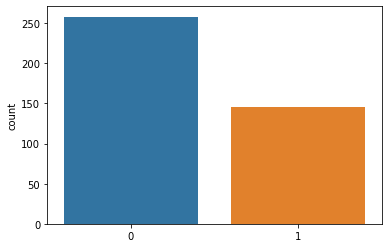

In [253]:
sns.countplot(y_test)

In [241]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

Naive Bayes

In [242]:
model_NB = MultinomialNB()
#.fit(X_train, y_train)

#y_pred = model_NB.predict(X_test)

Random Forest

In [211]:

model_RF = RandomForestClassifier(n_estimators=200, criterion='entropy').fit(X_train, y_train)
y_pred = model_RF.predict(X_test)

In [212]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[203  55]
 [ 64  81]]


In [213]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
print(f'Accuracy: {accuracy*100}%, Precision: {precision*100}%, Recall: {recall*100}%, F1-score: {f1*100}%')

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       258
           1       0.60      0.56      0.58       145

    accuracy                           0.70       403
   macro avg       0.68      0.67      0.67       403
weighted avg       0.70      0.70      0.70       403

Accuracy: 70.47146401985111%, Precision: 59.55882352941176%, Recall: 55.86206896551724%, F1-score: 57.65124555160141%


 **BEFORE removing URLs, Hashtags, Mentions; MOST_COMMON = 0**
 
 *BAG OF WORDS*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.76          | 0.65         | 0.72         | 0.68 
 Random Forest   | 0.73          | 0.62         | 0.66         | 0.64

 
 *TF - IDF*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.79         | 0.40         | 0.53 
 Random Forest   | 0.75          | 0.72         | 0.50         | 0.59
 
 
 **AFTER removing URLs, Hashtags, Mentions; MOST_COMMON = 0**
 
 *BAG OF WORDS*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.66         | 0.64         | 0.65 
 Random Forest   | 0.73          | 0.63         | 0.58         | 0.60

 
 *TF - IDF*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.66         | 0.64         | 0.65 
 Random Forest   | 0.70          | 0.60         | 0.56         | 0.58

In [ ]:
from emoji import UNICODE_EMOJI

def is_emoji(s):
    count = 0
    for emoji in UNICODE_EMOJI:
        count += s.count(emoji)
        if count > 1:
            return False
    return bool(count)

In [ ]:
def extract_emojis(s):
    return ''.join(c for c in s if c in UNICODE_EMOJI)

In [ ]:
sns.boxplot(x='supportive',y='followers_count',data=data)

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(x='followers_count',data=data)#,order=emp_length_order,hue='loan_status')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(data['followers_count'],kde=False,bins=40)
#plt.xlim(0,45000)